[![Open In Colab](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/badge/open-in-colab.svg)](https://colab.research.google.com/github/crunchdao/quickstarters/blob/master/competitions/structural-break/quickstarters/baseline/baseline.ipynb)
[![Open In Kaggle](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/badge/open-in-kaggle.svg)](https://www.kaggle.com/code/crunchdao/structural-break-baseline)

![Banner](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/master/competitions/structural-break/assets/banner.webp)

# ADIA Lab Structural Break Challenge

## Challenge Overview

Welcome to the ADIA Lab Structural Break Challenge! In this challenge, you will analyze univariate time series data to determine whether a structural break has occurred at a specified boundary point.

### What is a Structural Break?

A structural break occurs when the process governing the data generation changes at a certain point in time. These changes can be subtle or dramatic, and detecting them accurately is crucial across various domains such as climatology, industrial monitoring, finance, and healthcare.

![Structural Break Example](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/structural-break/quickstarters/baseline/images/example.png)

### Your Task

For each time series in the test set, you need to predict a score between `0` and `1`:
- Values closer to `0` indicate no structural break at the specified boundary point;
- Values closer to `1` indicate a structural break did occur.

### Evaluation Metric

The evaluation metric is [ROC AUC (Area Under the Receiver Operating Characteristic Curve)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), which measures the performance of detection algorithms regardless of their specific calibration.

- ROC AUC around `0.5`: No better than random chance;
- ROC AUC approaching `1.0`: Perfect detection.

# Setup

The first steps to get started are:
1. Get the setup command
2. Execute it in the cell below

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Reveal token](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/reveal-token.gif)

In [4]:
%pip install crunch-cli --upgrade --quiet --progress-bar off
!crunch setup-notebook structural-break ShVESVoFTDjuJwtasSOcflv9

Note: you may need to restart the kernel to use updated packages.
crunch-cli, version 7.4.0
delete /home/kureha/Documents/Coding_Projects/CrunchDao_structural_break_09_25/.crunchdao
you appear to have never submitted code before
data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
                                                                                
---
Success! Your environment has been correc

# Your model

## Setup

In [100]:
import os
import typing

# Import your dependencies
import joblib
import pandas as pd
import scipy
import sklearn.metrics

In [101]:
import crunch

# Load the Crunch Toolings
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>

cli version: 7.5.0
available ram: 22.88 gb
available cpu: 16 core
----


## Understanding the Data

The dataset consists of univariate time series, each containing ~2,000-5,000 values with a designated boundary point. For each time series, you need to determine whether a structural break occurred at this boundary point.

The data was downloaded when you setup your local environment and is now available in the `data/` directory.

In [102]:
# Load the data simply
X_train, y_train, X_test = crunch.load_data()

data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match


### Understanding `X_train`

The training data is structured as a pandas DataFrame with a MultiIndex:

**Index Levels:**
- `id`: Identifies the unique time series
- `time`: (arbitrary) The time step within each time series, which is regularly sampled

**Columns:**
- `value`: The values of the time series at each given time step
- `period`: whether you are in the first part of the time series (`0`), before the presumed break point, or in the second part (`1`), after the break point

In [103]:
X_train

value  period
id    time                  
0     0    -0.005564       0
      1     0.003705       0
      2     0.013164       0
      3     0.007151       0
      4    -0.009979       0
...              ...     ...
10000 2134  0.001137       1
      2135  0.003526       1
      2136  0.000687       1
      2137  0.001640       1
      2138  0.001074       1

[23715734 rows x 2 columns]

### Understanding `y_train`

This is a simple `pandas.Series` that tells if a time series id has a structural break, or not, from the presumed break point on.

**Index:**
- `id`: the ID of the time series

**Value:**
- `structural_breakpoint`: Boolean indicating whether a structural break occurred (`True`) or not (`False`)

In [104]:
y_train

id
0        False
1        False
2         True
3        False
4        False
         ...  
9996     False
9997     False
9998     False
9999     False
10000     True
Name: structural_breakpoint, Length: 10001, dtype: bool

### Understanding `X_test`

The test data is provided as a **`list` of `pandas.DataFrame`s** with the same format as [`X_train`](#understanding-X_test).

It is structured as a list to encourage processing records one by one, which will be mandatory in the `infer()` function.

In [105]:
print("Number of datasets:", len(X_test))

Number of datasets: 101


In [106]:
X_test[3]

value  period
id    time                  
10004 0     0.010101       0
      1     0.012000       0
      2     0.003953       0
      3     0.001968       0
      4    -0.049116       0
...              ...     ...
      3291 -0.021073       1
      3292  0.023483       1
      3293 -0.005736       1
      3294  0.023077       1
      3295 -0.041353       1

[3296 rows x 2 columns]

## Strategy Implementation

There are multiple approaches you can take to detect structural breaks:

1. **Statistical Tests**: Compare distributions before and after the boundary point;
2. **Feature Engineering**: Extract features from both segments for comparison;
3. **Time Series Modeling**: Detect deviations from expected patterns;
4. **Machine Learning**: Train models to recognize break patterns from labeled examples.

The baseline implementation below uses a simple statistical approach: a t-test to compare the distributions before and after the boundary point.

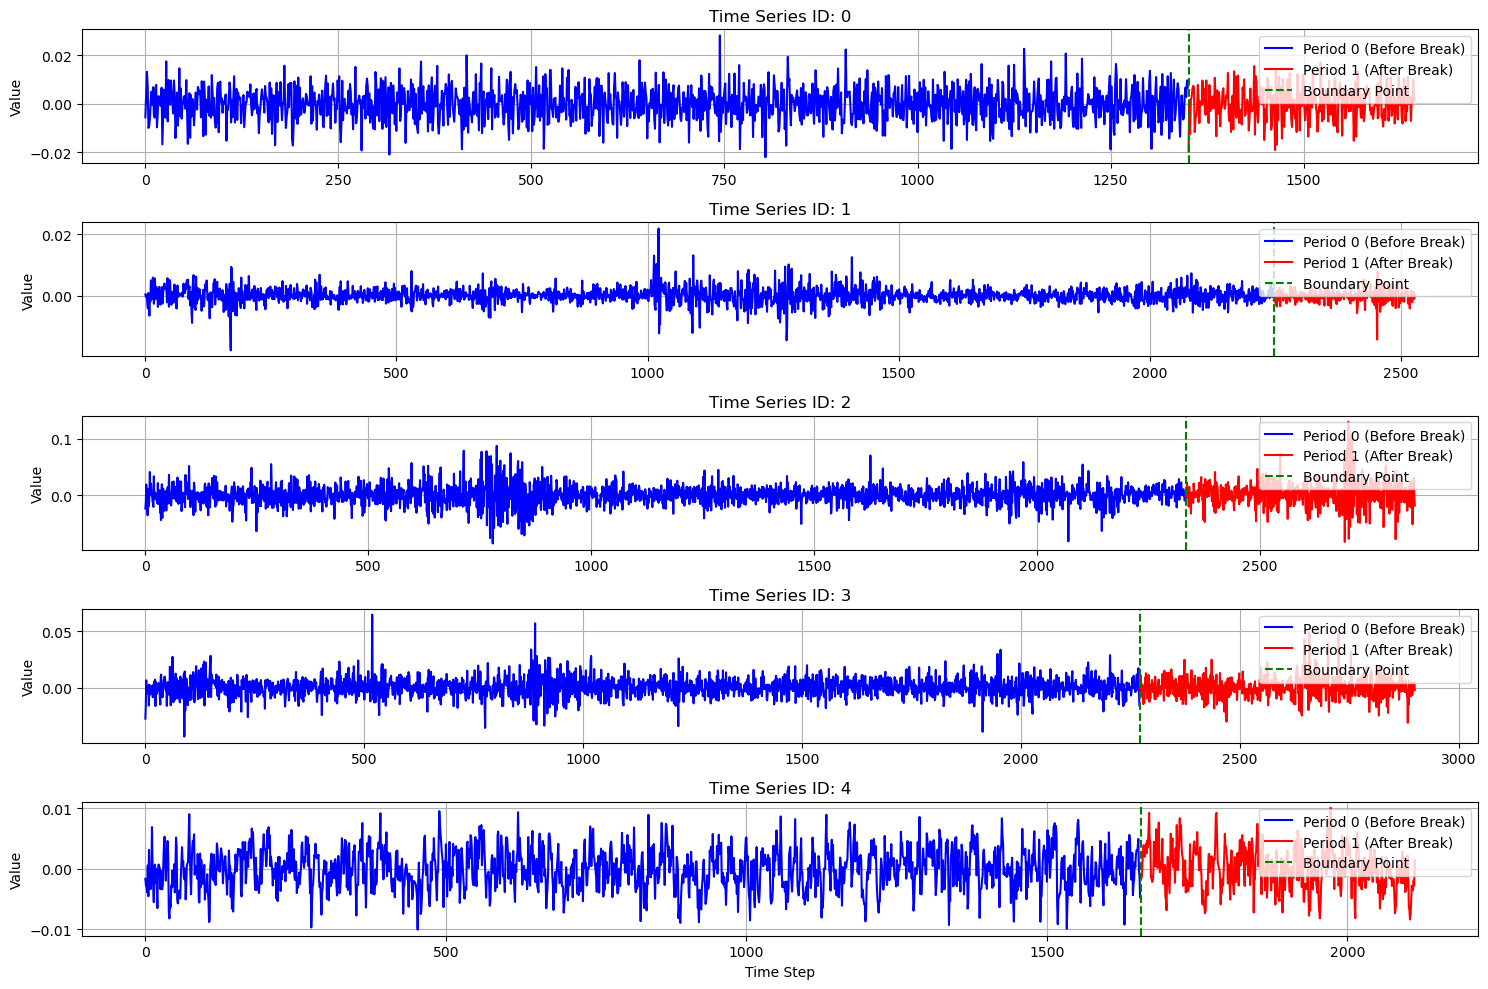

In [107]:
import matplotlib.pyplot as plt
import pandas as pd

unique_ids = X_train.index.get_level_values('id').unique()
num_series = 5

plt.figure(figsize=(15, 10))

for i, series_id in enumerate(unique_ids[:num_series]):
    # Select the data for a specific time series ID
    single_series_data = X_train.loc[series_id]

    # Get the values before the break point (period == 0)
    period_0_data = single_series_data[single_series_data['period'] == 0]['value']
    # Get the values after the break point (period == 1)
    period_1_data = single_series_data[single_series_data['period'] == 1]['value']

    plt.subplot(num_series, 1, i + 1) # Create a subplot for each series
    plt.plot(period_0_data.index, period_0_data.values, label='Period 0 (Before Break)', color='blue')
    plt.plot(period_1_data.index, period_1_data.values, label='Period 1 (After Break)', color='red')

    # Add a vertical line at the boundary point if desired
    # The boundary is where period changes from 0 to 1.
    # The last index of period 0 is the point right before the boundary.
    # The first index of period 1 is the point at or after the boundary.
    # A simple way to mark the boundary is to use the first 'time' index where period becomes 1.
    boundary_time = single_series_data[single_series_data['period'] == 1].index.min()
    if pd.notna(boundary_time):
        plt.axvline(x=boundary_time, color='green', linestyle='--', label='Boundary Point')


    plt.title(f'Time Series ID: {series_id}')
    plt.ylabel('Value')
    plt.legend(loc='upper right')
    plt.grid(True)

plt.xlabel('Time Step')
plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()


In [108]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print DEVICE

In [109]:
import gc # Import garbage collector
import torch

def clear_all_gpu_memory_and_objects():
    """
    Attempts to aggressively clear GPU memory and delete PyTorch-related objects
    from the global namespace in a Jupyter/IPython environment.
    """
    print("\n--- Attempting Aggressive GPU Memory Cleanup ---")

    # 1. Delete specific known global variables that might hold large objects
    #    (e.g., if you assigned model = train(...) in a cell)
    known_global_vars_to_delete = [
        'model', 'optimizer', 'criterion', 'train_loader', 'val_loader',
        'full_dataset', 'train_dataset', 'val_dataset', 'test_loader',
        'my_model_instance', # Add any other specific global names you might use
    ]
    
    for var_name in known_global_vars_to_delete:
        if var_name in globals():
            try:
                # Set to None first to break references, then delete
                globals()[var_name] = None
                del globals()[var_name]
                print(f"  - Deleted global variable: {var_name}")
            except NameError:
                pass # Already deleted or not found
            except Exception as e:
                print(f"  - Error deleting global {var_name}: {e}")

    # 2. More aggressively, iterate through all global variables and delete PyTorch tensors/modules.
    #    USE WITH CAUTION: This is powerful and might delete things you didn't intend to keep.
    #    It's primarily for situations where memory leaks are severe.
    deleted_count = 0
    for var_name, obj in list(globals().items()): # Use list() to avoid RuntimeError
        if isinstance(obj, (torch.Tensor, torch.nn.Module, torch.utils.data.Dataset, torch.utils.data.DataLoader)):
            try:
                globals()[var_name] = None
                del globals()[var_name]
                deleted_count += 1
                # print(f"  - Aggressively deleted global PyTorch object: {var_name}") # Uncomment for verbose
            except Exception as e:
                # print(f"  - Error deleting aggressive {var_name}: {e}") # Uncomment for verbose
                pass
    if deleted_count > 0:
        print(f"  - Aggressively deleted {deleted_count} PyTorch objects from global scope.")


    # 3. Force Python's garbage collector to run
    gc.collect()
    print("  - Python garbage collector called.")

    # 4. Clear PyTorch's CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("  - PyTorch CUDA cache cleared.")
    else:
        print("  - Not using CUDA, no cache to clear.")

In [116]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X_data: pd.DataFrame, y_data:typing.Optional[pd.Series], max_len_0: int, max_len_1: int, is_training: bool=False):
        self.max_len_0 = max_len_0
        self.max_len_1 = max_len_1
        self.ids = X_data.index.get_level_values('id').unique().tolist()
        self.X_data_grouped = X_data.groupby('id')
        self.y_data = y_data.loc[self.ids].values.astype(np.float32) if y_data is not None else None
        self.is_training = is_training
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        series_id = self.ids[idx]
        single_series_data = self.X_data_grouped.get_group(series_id)
        period_0_values = single_series_data[single_series_data['period'] == 0]['value'].values
        period_1_values = single_series_data[single_series_data['period'] == 1]['value'].values
        # z-score normalization
        if len(period_0_values) > 1 and np.std(period_0_values) != 0:
            period_0_normalized = (period_0_values - np.mean(period_0_values)) / np.std(period_0_values)
        else:
            period_0_normalized = np.zeros_like(period_0_values, dtype=np.float32)

        if len(period_1_values) > 1 and np.std(period_1_values) != 0:
            period_1_normalized = (period_1_values - np.mean(period_1_values)) / np.std(period_1_values)
        else:
            period_1_normalized = np.zeros_like(period_1_values, dtype=np.float32)

        # add jittering
        if self.is_training:
            jitter_strength = 0.05 # Adjust as needed (e.g., 5% of a typical std)
            period_0_normalized += np.random.normal(0, jitter_strength, period_0_normalized.shape).astype(np.float32)
            period_1_normalized += np.random.normal(0, jitter_strength, period_1_normalized.shape).astype(np.float32)

        # truncate if segment is longer than max_len
        truncated_0 = period_0_normalized[:self.max_len_0]
        truncated_1 = period_1_normalized[:self.max_len_1]
        pad_width_0 = self.max_len_0 - len(truncated_0)
        pad_width_1 = self.max_len_1 - len(truncated_1)
        
        padded_0 = np.pad(truncated_0, (0, pad_width_0), 'constant', constant_values=0).astype(np.float32)
        padded_1 = np.pad(truncated_1, (0, pad_width_1), 'constant', constant_values=0).astype(np.float32)

        tensor_0 = torch.tensor(padded_0, dtype=torch.float32).unsqueeze(1) # (max_len_0, 1)
        tensor_1 = torch.tensor(padded_1, dtype=torch.float32).unsqueeze(1) # (max_len_1, 1)

        if self.y_data is not None:
            label = torch.tensor(self.y_data[idx], dtype=torch.float32)
            return tensor_0, tensor_1, label
        else:
            return tensor_0, tensor_1





In [117]:
class CNN_RNN_Model(nn.Module):
    def __init__(self, max_len_0: int, max_len_1: int):
        super(CNN_RNN_Model, self).__init__()

        def cnn_block():
            return nn.Sequential(
                nn.Conv1d(in_channels=1, out_channels=128, kernel_size=5, padding='same'),
                nn.BatchNorm1d(128),
                nn.ReLU(), # Changed from GELU to ReLU
                nn.MaxPool1d(kernel_size=2),

                nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
                nn.BatchNorm1d(256),
                nn.ReLU(), # Changed from GELU to ReLU
                nn.MaxPool1d(kernel_size=2),

                nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
                nn.BatchNorm1d(256),
                # No activation after the last Conv1D in the image (or it's the output layer for this block)
                nn.ReLU(), # Added ReLU here to be consistent with common CNN block design, though image shows output directly
                nn.MaxPool1d(kernel_size=2)
            )
        
        self.cnn_branch_0 = cnn_block()
        self.cnn_branch_1 = cnn_block()

        # Dummy input/output calculations need to be updated after changing CNN block
        dummy_input_0 = torch.zeros(1, 1, max_len_0) 
        dummy_output_0 = self.cnn_branch_0(dummy_input_0)
        
        dummy_input_1 = torch.zeros(1, 1, max_len_1)
        dummy_output_1 = self.cnn_branch_1(dummy_input_1) 
        
        # --- Changed GRU to LSTM ---
        self.rnn_branch_0 = nn.LSTM(input_size=dummy_output_0.shape[1], hidden_size=128, bidirectional=True, batch_first=True)
        self.rnn_branch_1 = nn.LSTM(input_size=dummy_output_1.shape[1], hidden_size=128, bidirectional=True, batch_first=True)

        # --- Simplified Classifier Head ---
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 * 2, 128), # Reduced intermediate layer size
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.6), # Maintain high dropout

            nn.Linear(128, 64), # Another reduction
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.6), # Maintain high dropout

            nn.Linear(64, 1), # Final output layer
        )

    def forward(self, x0, x1):
        x0 = x0.permute(0, 2, 1) 
        x1 = x1.permute(0, 2, 1) 

        x0 = self.cnn_branch_0(x0) 
        x1 = self.cnn_branch_1(x1)

        x0 = x0.permute(0, 2, 1)
        x1 = x1.permute(0, 2, 1)

        # --- Adjusted for LSTM output: LSTM returns (output, (h_n, c_n)) ---
        _, (h0, _) = self.rnn_branch_0(x0)
        _, (h1, _) = self.rnn_branch_1(x1)

        h0_combined = torch.cat((h0[-2, :, :], h0[-1, :, :]), dim=1) 
        h1_combined = torch.cat((h1[-2, :, :], h1[-1, :, :]), dim=1)

        merged = torch.cat((h0_combined, h1_combined), dim=1) 

        output_logits = self.classifier(merged) 
        return output_logits.squeeze(1)


### The `train()` Function

In this function, you build and train your model for making inferences on the test data. Your model must be stored in the `model_directory_path`.

The baseline implementation below doesn't require a pre-trained model, as it uses a statistical test that will be computed at inference time.

In [118]:
def train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model_directory_path: str,
):
    MAX_POSSIBLE_LEN = 4096

    max_len_0 = 2048
    max_len_1 = 2048
    
    # Pass is_training=True to the TimeSeriesDataset for augmentation
    full_dataset = TimeSeriesDataset(X_train, y_train, max_len_0, max_len_1, is_training=True)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count() // 2)
    # Ensure validation dataset does NOT have augmentation
    # Note: `val_dataset.dataset` might refer to the original `full_dataset` if `random_split`
    # returns `Subset` objects. For `Subset` objects, you access the underlying dataset via `.dataset`.
    # Make sure this correctly disables augmentation for the validation set only.
    val_dataset.dataset.is_training = False 
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count() // 2)

    model = CNN_RNN_Model(max_len_0, max_len_1).to(DEVICE)
    print(model)

    # --- Adjusted Learning Rate and Increased Weight Decay ---
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2) # Stronger L2 regularization
    
    neg_count = (y_train == 0).sum()
    pos_count = (y_train == 1).sum()
    pos_weight = torch.tensor(neg_count / pos_count, dtype=torch.float32).to(DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    print(f"Using BCEWithLogitsLoss with pos_weight: {pos_weight.item():.2f}")
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max', # Monitor validation ROC AUC (we want to maximize it)
        factor=0.5, # Reduce LR by 50%
        patience=5, # If Val ROC AUC doesn't improve for 5 epochs, reduce LR
        verbose=True,
        min_lr=1e-7 # Don't let LR go below this
    )

    best_val_roc_auc = -1.0
    patience_counter = 0
    PATIENCE = 20 # Increased early stopping patience to give more chance for slow improvements
    EPOCHS = 100 

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_targets = []

        for batch_idx, (x0_batch, x1_batch, labels_batch) in enumerate(train_loader):
            try:
                x0_batch, x1_batch, labels_batch = x0_batch.to(DEVICE), x1_batch.to(DEVICE), labels_batch.to(DEVICE)

                optimizer.zero_grad()
                outputs = model(x0_batch, x1_batch)

                # --- Debugging Check 1: Check for NaNs/Infs in outputs ---
                if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                    print(f"WARNING: NaN or Inf detected in model outputs at Epoch {epoch}, Batch {batch_idx}")
                    raise RuntimeError("NaN or Inf in model outputs")

                loss = criterion(outputs, labels_batch)

                # --- Debugging Check 2: Check for NaNs/Infs in loss ---
                if torch.isnan(loss).any() or torch.isinf(loss).any():
                    print(f"WARNING: NaN or Inf detected in loss at Epoch {epoch}, Batch {batch_idx}")
                    raise RuntimeError("NaN or Inf in loss calculation")

                loss.backward()

                # --- Gradient Clipping ---
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Helps stabilize gradients

                # --- Debugging Check 3: Check for NaNs/Infs in gradients ---
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                            print(f"WARNING: NaN or Inf detected in gradients for '{name}' at Epoch {epoch}, Batch {batch_idx}")
                            raise RuntimeError(f"NaN or Inf in gradients for {name}")

                optimizer.step()

                train_loss += loss.item()
                train_preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
                train_targets.extend(labels_batch.cpu().numpy())

            except Exception as e:
                print(f"\nERROR: Caught exception in Epoch {epoch}, Batch {batch_idx}: {type(e).__name__}: {e}")
                raise 

        avg_train_loss = train_loss / len(train_loader)
        train_roc_auc = roc_auc_score(train_targets, train_preds)

        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for x0_batch, x1_batch, labels_batch in val_loader:
                x0_batch, x1_batch, labels_batch = x0_batch.to(DEVICE), x1_batch.to(DEVICE), labels_batch.to(DEVICE)
                outputs = model(x0_batch, x1_batch)
                loss = criterion(outputs, labels_batch)
                val_loss += loss.item()
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                val_targets.extend(labels_batch.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_roc_auc = roc_auc_score(val_targets, val_preds)

        print(f"Epoch {epoch+1}/{EPOCHS}: "
              f"Train Loss: {avg_train_loss:.4f}, Train ROC AUC: {train_roc_auc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}")

        scheduler.step(val_roc_auc)

        if val_roc_auc > best_val_roc_auc:
            best_val_roc_auc = val_roc_auc
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(model_directory_path, 'cnn_rnn_model_best.pth'))
            print(f"  --> New best model saved with Val ROC AUC: {best_val_roc_auc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping triggered after {patience_counter} epochs without improvement.")
                break
        
        joblib.dump(
            {'max_len_0': max_len_0, 'max_len_1': max_len_1},
            os.path.join(model_directory_path, 'nn_params.joblib')
        )

### The `infer()` Function

In the inference function, your trained model (if any) is loaded and used to make predictions on test data.

**Important workflow:**
1. Load your model;
2. Use the `yield` statement to signal readiness to the runner;
3. Process each dataset one by one within the for loop;
4. For each dataset, use `yield prediction` to return your prediction.

**Note:** The datasets can only be iterated once!

In [119]:
def infer(
    X_test: typing.Iterable[pd.DataFrame],
    model_directory_path: str,
):
    nn_params = joblib.load(os.path.join(model_directory_path, 'nn_params.joblib'))
    max_len_0 = nn_params['max_len_0']
    max_len_1 = nn_params['max_len_1']
    model = CNN_RNN_Model(max_len_0, max_len_1).to(DEVICE)
    model.load_state_dict(torch.load(os.path.join(model_directory_path, 'cnn_rnn_model_best.pth'), map_location=DEVICE))
    model.eval()

    yield  # Mark as ready

    # X_test can only be iterated once.
    # Before getting the next dataset, you must predict the current one.
    for dataset in X_test:
        x0_tensor, x1_tensor = TimeSeriesDataset(dataset, None, max_len_0, max_len_1)[0]
        x0_input = x0_tensor.unsqueeze(0).to(DEVICE)
        x1_input = x1_tensor.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            output_logits = model(x0_input, x1_input)
            prediction = torch.sigmoid(output_logits).item()
        
        yield prediction  # Send the prediction for the current dataset

        
        # Note: This baseline approach uses a t-test to compare the distributions
        # before and after the boundary point. A smaller p-value (larger negative number)
        # suggests stronger evidence that the distributions are different,
        # indicating a potential structural break.

## Local testing

To make sure your `train()` and `infer()` function are working properly, you can call the `crunch.test()` function that will reproduce the cloud environment locally. <br />
Even if it is not perfect, it should give you a quick idea if your model is working properly.

In [120]:
crunch.test(
    # Uncomment to disable the train
    # force_first_train=False,

    # Uncomment to disable the determinism check
    # no_determinism_check=True,
)

ignoring cell #2: unexpected indent (<unknown>, line 25)
ignoring cell #23: unindent does not match any outer indentation level (<unknown>, line 157)
ignoring cell #72: unexpected indent (<unknown>, line 50)
ignoring cell #95: '(' was never closed (<unknown>, line 124)


10:54:56 no forbidden library found
10:54:56 
10:54:56 started
10:54:56 running local test
10:54:56 internet access isn't restricted, no check will be done
10:54:56 
10:54:56 starting unstructured loop...
10:54:56 executing - command=train


data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match
CNN_RNN_Model(
  (cnn_branch_0): Sequential(
    (0): Conv1d(1, 128, kernel_size=(5,), stride=(1,), padding=same)
   

Traceback (most recent call last):
  File "https://github.com/crunchdao/competitions/raw/refs/heads/master/competitions/structural-break/scoring/runner.py", line 27, in run
  File "/home/kureha/anaconda3/lib/python3.12/site-packages/crunch/runner/local.py", line 559, in execute
    result = utils.smart_call(
             ^^^^^^^^^^^^^^^^^
  File "/home/kureha/anaconda3/lib/python3.12/site-packages/crunch/utils.py", line 270, in smart_call
    return function(**arguments)
           ^^^^^^^^^^^^^^^^^^^^^
  File "https://github.com/crunchdao/competitions/raw/refs/heads/master/competitions/structural-break/scoring/runner.py", line 78, in train
  File "/home/kureha/anaconda3/lib/python3.12/site-packages/crunch/utils.py", line 270, in smart_call
    return function(**arguments)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4292/1468117186.py", line 84, in train
    if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                                        ^^^^^^^^^^

AttributeError: 'tuple' object has no attribute 'tb_frame'

In [99]:
clear_all_gpu_memory_and_objects()


--- Attempting Aggressive GPU Memory Cleanup ---
  - Python garbage collector called.
  - PyTorch CUDA cache cleared.


## Results

Once the local tester is done, you can preview the result stored in `data/prediction.parquet`.

In [52]:
prediction = pd.read_parquet("data/prediction.parquet")
prediction

,prediction
id,
10001,0.588449
10002,0.432344
10003,0.476639
10004,0.573177
10005,0.591035
...,...
10097,0.436783
10098,0.384288
10099,0.648564


### Local scoring

You can call the function that the system uses to estimate your score locally.

In [53]:
# Load the targets
target = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"]

# Call the scoring function
sklearn.metrics.roc_auc_score(
    target,
    prediction,
)

0.39248826291079814

# Submit your Notebook

To submit your work, you must:
1. Download your Notebook from Colab
2. Upload it to the platform
3. Create a run to validate it

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Download and Submit Notebook](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/download-and-submit-notebook.gif)